### Imports

In [53]:
import numpy as np
import pandas as pd
import gensim
import itertools
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import pylab
import json
from lapsolver import solve_dense
from numpy.linalg import norm
from numba import njit

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline
tqdm.pandas()

### Load in the captions DataFrame

In [2]:
df = pd.read_csv('../data/2017/captions.csv')
print(len(df))
df.head()

3242


,coco_url,height,width,id,captions
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,rolling pots oven pies table standing near mad...
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,decorated ready small kitchen near clean see w...
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,past city walking dwellers walk standing next ...
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,skateboard tricks falls bike air performs skat...
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,fixture walk blue sidewalk locked next side ne...


### Load in the Word2Vec model

In [3]:
limit = 100000
model = gensim.models.KeyedVectors.load_word2vec_format('../data/wiki.vec',
                                                       binary=False,
                                                       limit=limit)
model.init_sims(replace=True)

c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Map the captions to indices of an array of Word2Vec vectors

In [22]:
vec_arr = []
word_dict = {}
def caption_to_vec(text):
    vec = []
    for word in text.split():
        if word not in model:
            continue
        if word not in word_dict:
            idx = len(word_dict.keys())
            word_dict[word] = idx
            vec_arr.append(model[word])
        vec.append(word_dict[word])
    return np.array(vec, dtype=np.int)

df['captions_vec'] = df['captions'].progress_apply(lambda text: caption_to_vec(text))
vec_arr = np.array(vec_arr)
print(f'There are {vec_arr.shape[0]} unique words')


There are 5070 unique words


In [25]:
df.head()

,coco_url,height,width,id,captions,captions_vec
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,rolling pots oven pies table standing near mad...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,decorated ready small kitchen near clean see w...,"[22, 23, 24, 15, 6, 25, 26, 27, 28, 29, 30, 4,..."
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,past city walking dwellers walk standing next ...,"[35, 36, 37, 38, 39, 5, 40, 41, 42, 43, 44, 45..."
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,skateboard tricks falls bike air performs skat...,"[51, 52, 53, 54, 55, 56, 57, 58, 18, 10, 59, 6..."
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,fixture walk blue sidewalk locked next side ne...,"[65, 39, 66, 67, 68, 40, 69, 6, 54, 70, 36, 71..."


### Precompute the cosine similarity between each pair of words

In [6]:
@njit
def sigmoid(x):
    return 1 / (1 + 20*np.exp(-20*(x - 0.4)))

@njit
def create_pair_to_dist(vec_arr):
    W = vec_arr.shape[0]
    pair_to_dist = np.zeros(shape=(W, W), dtype=np.float32)
    for i in range(W):
        for j in range(i+1, W):
            u, v = vec_arr[i], vec_arr[j]
            # d = sigmoid(np.dot(u, v)/(norm(u)*norm(v)))
            d = np.dot(u, v)/(norm(u)*norm(v))
            pair_to_dist[i][j] = d
            pair_to_dist[j][i] = d
    return pair_to_dist

pair_to_dist = create_pair_to_dist(vec_arr)

### Calculate the earthmover distance between each pair of captions

In [28]:
@njit(fastmath=True)
def calculate_dist_matrix(u, v, d):
    mat = np.zeros(shape=(u.shape[0], v.shape[0]), dtype=np.float32)
    for i in range(u.shape[0]):
        for j in range(v.shape[0]):
            mat[i][j] = d[u[i]][v[j]]
    return mat


@njit(fastmath=True)
def numba_mean(arr):
    total = 0
    for a in arr:
        total += a
    return total/arr.shape[0]


def earthmover(u, v):
    dist_matrix = calculate_dist_matrix(u, v, pair_to_dist)
    assignment = solve_dense(dist_matrix)
    score = numba_mean(dist_matrix[assignment])
    return score


def create_ids_to_dist(captions_vecs, ids):
    ids_to_dist = {}
    for i in tqdm(range(len(ids))):
        for j in range(i+1, len(ids)):
            id_u, id_v = ids[i], ids[j]
            u, v = captions_vecs[i], captions_vecs[j]
            score = earthmover(u, v)
            ids_to_dist[(id_u, id_v)] = score
            ids_to_dist[(id_v, id_u)] = score
    return ids_to_dist

captions_vecs = list(df['captions_vec'])
ids = list(df['id'])
ids_to_dist = create_ids_to_dist(captions_vecs, ids)

### Save a list of the ids and the map between pairs of ids and their distance

In [ ]:
print(ids[:5])
print(list(ids_to_dist.keys())[:3], list(ids_to_dist.values())[:3])

[397133, 37777, 252219, 87038, 174482]
[(397133, 37777), (37777, 397133), (397133, 252219)] 

In [29]:
np.save('ids.npy', ids)
np.save('ids_to_dist.npy', ids_to_dist)

### Find the closest picture to the given id

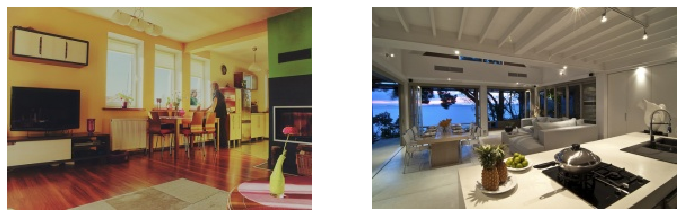

In [109]:
def calculate_closest_id(idx):
    possible_ids = ids[:]
    possible_ids.remove(idx)
    dists = np.array([(i, ids_to_dist[(idx, i)]) for i in possible_ids])
    
    closest_id, smallest_dist = min(dists, key=lambda x: x[1])
    return int(closest_id)

random_id = np.random.choice(df['id'])
closest_id = calculate_closest_id(random_id)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, idx in enumerate([random_id, closest_id]):
    path = f'../../static/pictures/{idx}.jpg'
    img = io.imread(path)
    ax[i].imshow(img)
    ax[i].axis('off')